In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

In [28]:
# Load your dataset
file_path = r"C:\Program Files\Lung Cancer\dataset_med.csv"

try:
    df = pd.read_csv(file_path)
    print("File loaded successfully!")
    print("Dataset shape:", df.shape)
    print("\nFirst 5 rows:")
    display(df.head())
except Exception as e:
    print("Error loading file:", e)

File loaded successfully!
Dataset shape: (890000, 17)

First 5 rows:


,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


In [30]:
# Data Cleaning
# Convert dates to datetime format if they exist
if 'diagnosis_date' in df.columns:
    df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'])
if 'end_treatment_date' in df.columns:
    df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'])

# Calculate treatment duration if both date columns exist
if all(col in df.columns for col in ['diagnosis_date', 'end_treatment_date']):
    df['treatment_duration'] = (df['end_treatment_date'] - df['diagnosis_date']).dt.days

# Drop columns that might not be useful for prediction
columns_to_drop = ['id', 'diagnosis_date', 'end_treatment_date', 'country']
df = df.drop([col for col in columns_to_drop if col in df.columns], axis=1)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Handle missing values in numerical columns
numerical_cols = ['age', 'bmi', 'cholesterol_level', 'treatment_duration'] if 'treatment_duration' in df.columns else ['age', 'bmi', 'cholesterol_level']
imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Display cleaned data
print("\nCleaned data:")
display(df.head())


Missing values:
age                   0
gender                0
cancer_stage          0
family_history        0
smoking_status        0
bmi                   0
cholesterol_level     0
hypertension          0
asthma                0
cirrhosis             0
other_cancer          0
treatment_type        0
survived              0
treatment_duration    0
dtype: int64

Cleaned data:


,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,survived,treatment_duration
0,64.0,Male,Stage I,Yes,Passive Smoker,29.4,199.0,0,0,1,0,Chemotherapy,0,523.0
1,50.0,Female,Stage III,Yes,Passive Smoker,41.2,280.0,1,1,0,0,Surgery,1,424.0
2,65.0,Female,Stage III,Yes,Former Smoker,44.0,268.0,1,1,0,0,Combined,0,370.0
3,51.0,Female,Stage I,No,Passive Smoker,43.0,241.0,1,1,0,0,Chemotherapy,0,443.0
4,37.0,Male,Stage I,No,Passive Smoker,19.7,178.0,0,0,0,0,Combined,0,406.0


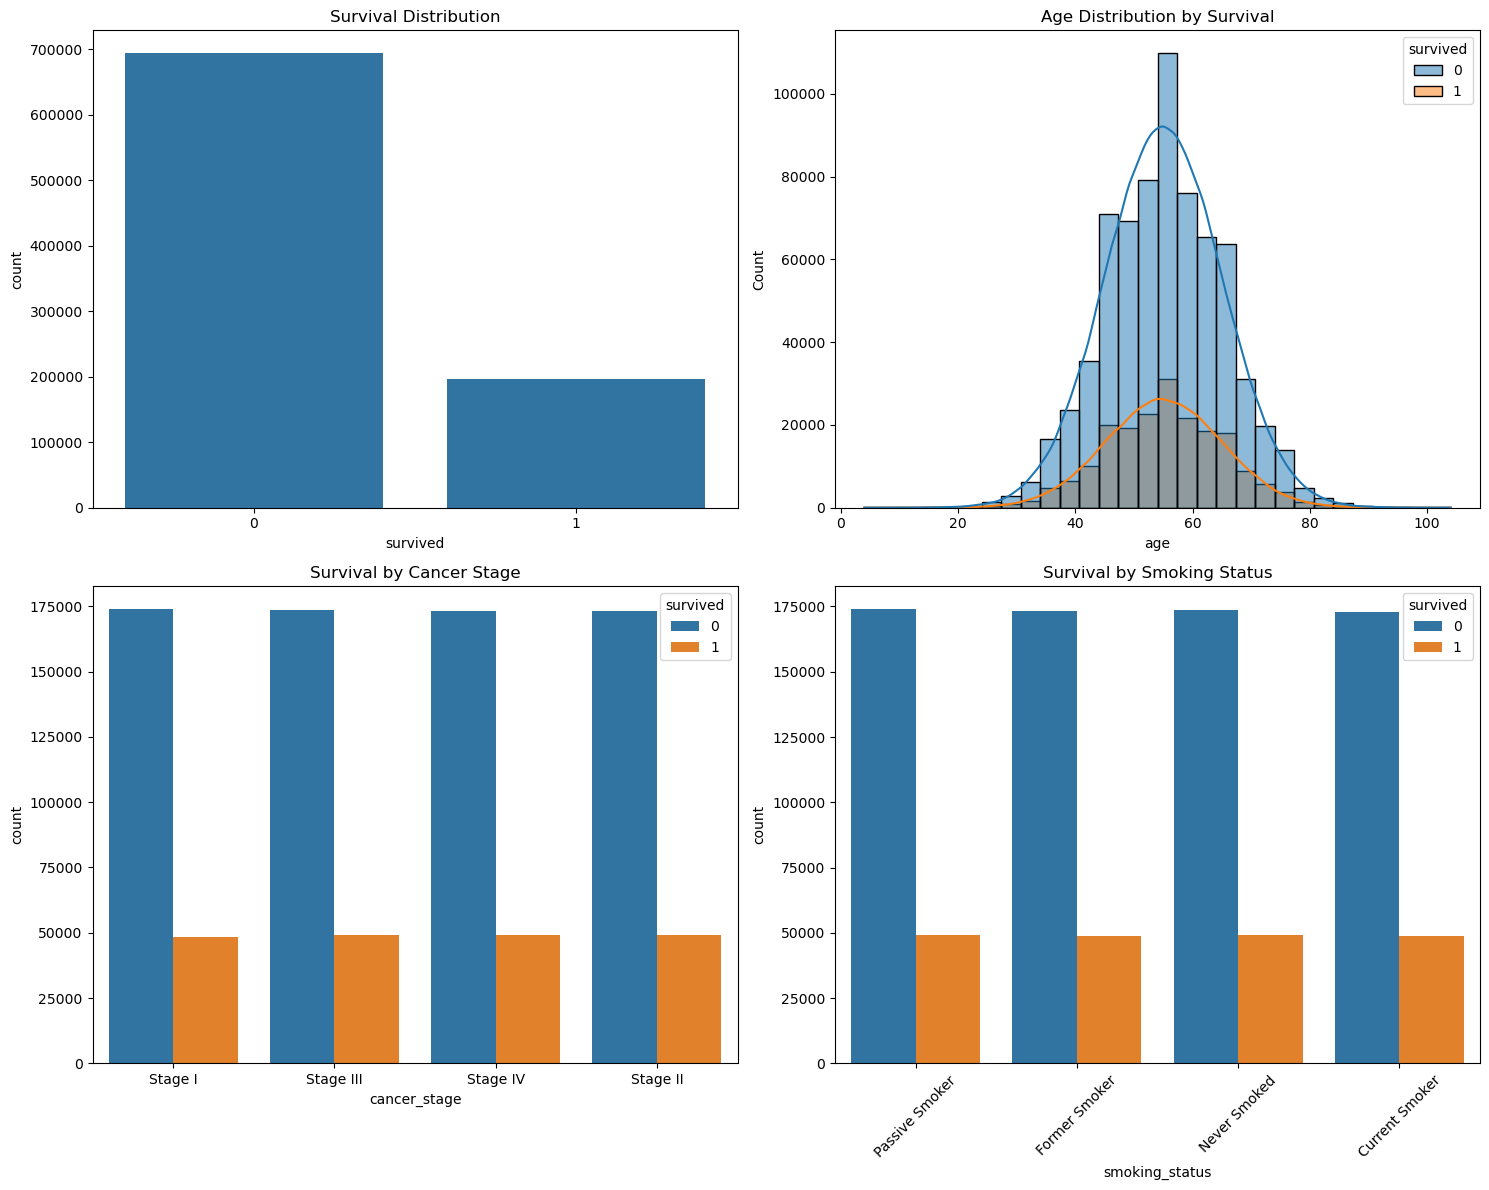

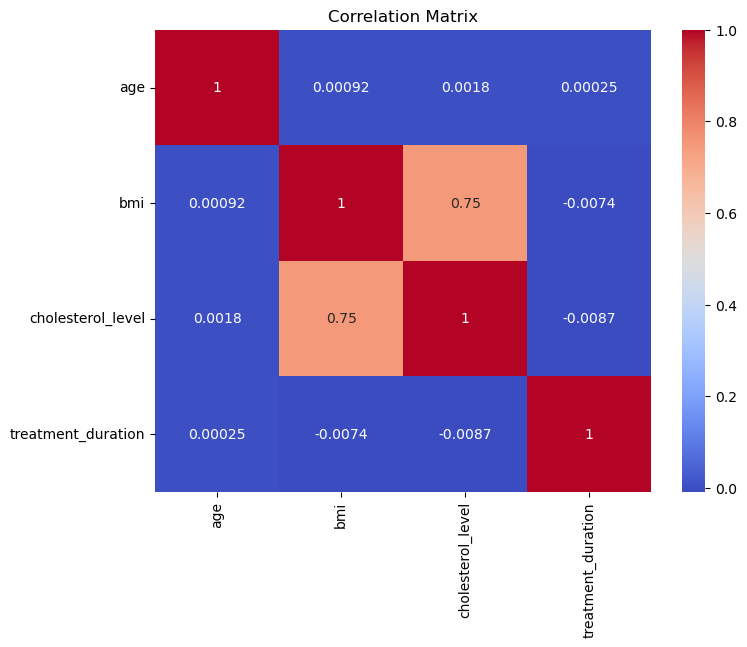

In [32]:
# EDA - Visualizations
plt.figure(figsize=(15, 12))

# Survival rate
plt.subplot(2, 2, 1)
sns.countplot(x='survived', data=df)
plt.title('Survival Distribution')

# Age distribution by survival
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='age', hue='survived', kde=True, bins=30)
plt.title('Age Distribution by Survival')

# Cancer stage vs survival
plt.subplot(2, 2, 3)
sns.countplot(x='cancer_stage', hue='survived', data=df)
plt.title('Survival by Cancer Stage')

# Smoking status vs survival
plt.subplot(2, 2, 4)
sns.countplot(x='smoking_status', hue='survived', data=df)
plt.title('Survival by Smoking Status')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Correlation matrix
numerical_cols = [col for col in ['age', 'bmi', 'cholesterol_level', 'treatment_duration'] if col in df.columns]
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [34]:
# Feature Engineering and Preprocessing
# Encode categorical variables
label_encoders = {}
categorical_cols = ['gender', 'cancer_stage', 'family_history', 'smoking_status', 
                   'hypertension', 'asthma', 'cirrhosis', 'other_cancer', 'treatment_type']
categorical_cols = [col for col in categorical_cols if col in df.columns]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert to string before encoding
    label_encoders[col] = le

# Encode target variable
df['survived'] = LabelEncoder().fit_transform(df['survived'])

# Scale numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display processed data
print("\nProcessed data:")
display(df.head())


Processed data:


,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,survived,treatment_duration
0,0.899796,1,0,1,3,-0.130748,-0.797424,0,0,1,0,0,0,0.465906
1,-0.500977,0,2,1,3,1.279296,1.067550,1,1,0,0,3,1,-0.244658
2,0.999851,0,2,1,1,1.613882,0.791257,1,1,0,0,1,0,-0.632238
3,-0.400922,0,0,0,3,1.494387,0.169599,1,1,0,0,0,0,-0.108287
4,-1.801696,1,0,0,3,-1.289852,-1.280936,0,0,0,0,1,0,-0.373851


In [36]:
# Prepare data for modeling
X = df.drop('survived', axis=1)
y = df['survived']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (623000, 13)
Test set shape: (267000, 13)


In [38]:
# Build and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Model trained successfully!")

Model trained successfully!


Accuracy: 0.7781161048689138

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88    207984
           1       0.22      0.00      0.00     59016

    accuracy                           0.78    267000
   macro avg       0.50      0.50      0.44    267000
weighted avg       0.66      0.78      0.68    267000



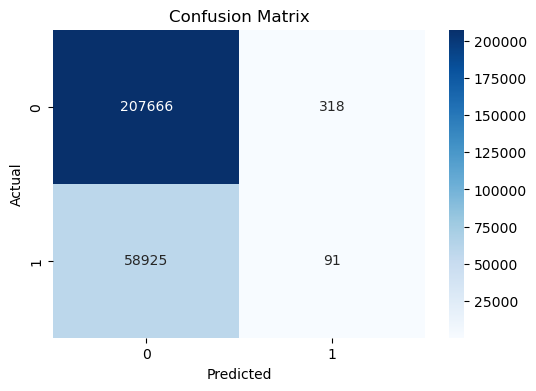

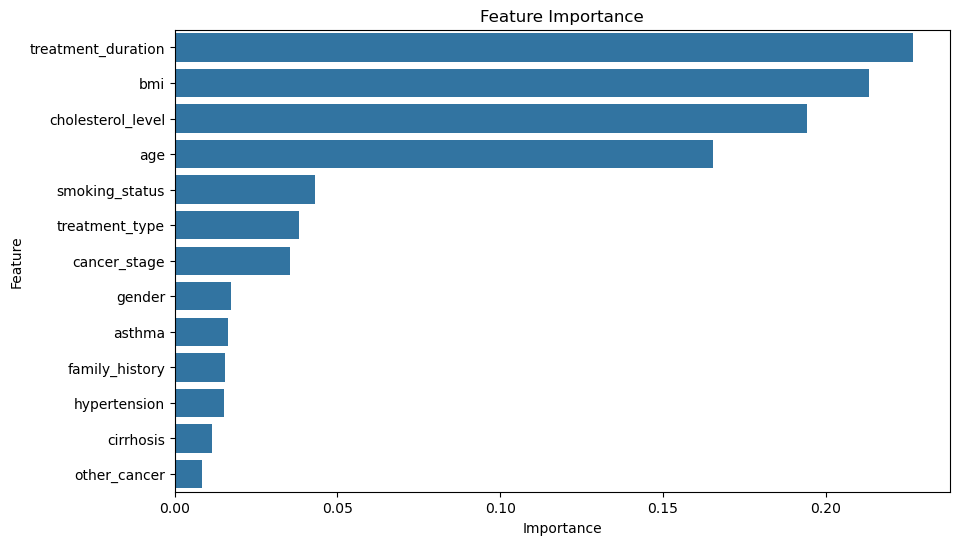

In [40]:
# Model Evaluation
y_pred = model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

In [ ]:
import joblib

def save_model(model, scaler):
    joblib.dump(model, 'lung_cancer_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    print("Model and scaler saved successfully!")

save_model(model, scaler)